In [1]:
import tensorflow as tf
import edward as ed
import numpy as np
import seaborn as sns
import pandas as pd

from edward.models import Normal

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats import skew, kurtosis
from sklearn.preprocessing import scale

%matplotlib inline
plt.style.use('seaborn')

In [37]:
train_data = pd.read_csv('train.csv')

# Isolate and log-transform all numeric data
numeric_data = train_data.dtypes[train_data.dtypes != 'object'].index
skewed = train_data[numeric_data].apply(lambda x: skew(x.dropna()))
skewed = skewed[skewed > 0.2].index
train_data[skewed] = np.log1p(train_data[skewed])
# Apparently this gets "dummy data" for categorical data
train_data = pd.get_dummies(train_data) # this is pretty sick
# fill nansies
train_data = train_data.fillna(train_data.mean())
train_data.reset_index(inplace=True)

X_train = (train_data.drop('SalePrice', axis=1))
X_train = scale(X_train)
prices = scale(np.asarray(train_data['SalePrice']))
N = X_train.shape[0] # number of data points
D = X_train.shape[1] # number of features

In [38]:
x = tf.placeholder(tf.float32, [N, D]) # training data placeholder
# Hyperpriors:
mn_offset = np.mean(prices, axis=0)

mu_A = Normal(loc=mn_offset*tf.ones(1), scale=tf.ones(1))
sd_A = Normal(loc=tf.zeros(1), scale=tf.ones(1))

mu_B = Normal(loc=tf.zeros(D), scale=tf.ones(D))
sd_B = Normal(loc=tf.zeros(D), scale=tf.ones(D))

# The model is of the form mu = A + Bx

B = Normal(loc=mu_B, scale=sd_B)
A = Normal(loc=mu_A, scale=sd_A)

# model
M_y = A + ed.dot(x, B)
y = Normal(loc=M_y, scale=tf.ones(N))

# approximate distributions
qB = Normal(
    loc=tf.Variable(tf.random_normal([D])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))

qA = Normal(
    loc=tf.Variable(mn_offset+tf.random_normal([1])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

qMA = Normal(
    loc=tf.Variable(mn_offset+tf.random_normal([1])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

qMB = Normal(
    loc=tf.Variable(tf.random_normal([D])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))

qSA =  Normal(
    loc=tf.Variable(mn_offset+tf.random_normal([1])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

qSB = Normal(
    loc=tf.Variable(tf.random_normal([D])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))

In [39]:
latent_vars = {
    A: qA,
    B: qB,
    mu_A: qMA,
    mu_B: qMB,
    sd_A: qSA,
    sd_B: qSB    
}

In [40]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)
tf.global_variables_initializer().run()

In [41]:
inference = ed.KLqp(latent_vars, data={x: X_train, y: prices})
inference.run(n_samples=5, n_iter=10000)

10000/10000 [100%] ██████████████████████████████ Elapsed: 137s | Loss: 95309.305


In [42]:
yp = ed.copy(y, latent_vars)

In [43]:
print(ed.evaluate('mse', data={x: X_train, yp: (prices)}))

38.7497


In [44]:
aa = yp.sample(400).eval(feed_dict={x: X_train})

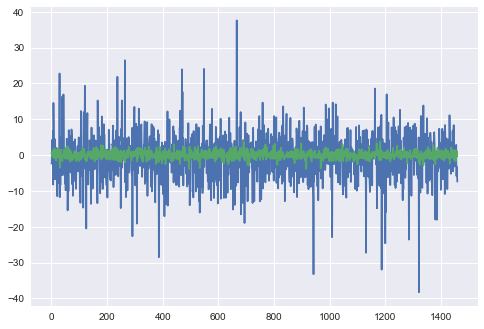

In [45]:
plt.plot(np.mean(aa, axis=0))
plt.plot(prices)